In [4]:
import numpy as np
import torch
from speed_tests import PyTorch, NumPy
from torch.nn import MSELoss
import numpy.linalg as LA
from torch.autograd import Variable
import time
torch.__version__

'0.4.1'

In [65]:
import autograd
import autograd.numpy as anp

n, d = int(10e3), 1000
A = np.random.randn(n, d)
x = np.random.rand(d)
y = A @ x

def loss(x):
    return ((anp.dot(A, x) - y)**2).mean()

x_hat = np.random.rand(d)

In [66]:
%time g1 = autograd.grad(loss)(x_hat)

CPU times: user 23.8 ms, sys: 2.09 ms, total: 25.9 ms
Wall time: 13.7 ms


In [67]:
%time g2 = numpy_grad(A, x_hat, y)

CPU times: user 72 ms, sys: 45.1 ms, total: 117 ms
Wall time: 103 ms


In [51]:
import autograd.numpy as anp

def torch_grad(A, x, y):
    mse = MSELoss()
    m = mse.forward(A @ x, y)
    m.backward()
    return x.grad / len(y)
        
def numpy_grad(A, x, y):
    return (2*A.T@(A@x - y)) / len(y)

def hips_grad(A, x, y):
    loss = lambda x: ((anp.dot(A, x) - y)**2).sum() / len(y)
    return autograd.grad(loss)(x)

In [52]:
def time_fn(fn, *args, limit=1, **kwargs):
    times = []
    start_time = time.time()
    while True:
        start = time.time()
        r = fn(*args, **kwargs)
        end = time.time()
        times += [end - start]
        if time.time() - start_time > limit:
            break
    if type(r) != np.ndarray:
        r = r.data.numpy()
    return {'result': r,
            'result_norm': np.linalg.norm(r),
            'time': min(times),
            'repeats': len(times)}

In [53]:
def time_fn_with_size(fn, n=None, d=10, seed=42, library='numpy'):
    np.random.seed(42)
    n = 10*d
    A = np.random.randn(n, d)
    x = np.random.randn(d)
    y = A@x + n * 0.1 * np.random.randn(n)
    if library == 'pytorch':
        A = Variable(torch.from_numpy(A), requires_grad=False)
        y = Variable(torch.from_numpy(y), requires_grad=False)
        x = Variable(torch.from_numpy(x), requires_grad=True)
    return {'library': library,
            'seed': seed, 'n': n, 'd': d,
            **time_fn(fn, A, x, y)}

In [54]:
data = []

In [55]:
seed = 42
libraries = {'pytorch': torch_grad,
             'hips': hips_grad,
             'numpy': numpy_grad}

for repeat in range(10):
    for library, fn in libraries.items():
        print(repeat, fn)
        for d in np.logspace(1, np.log10(5e3), num=10, dtype=int):
            data += [time_fn_with_size(fn, d=d, seed=seed, library=library)]

0 <function torch_grad at 0x11ae3c6a8>
0 <function hips_grad at 0x11ae3c7b8>
0 <function numpy_grad at 0x11ae3c730>
1 <function torch_grad at 0x11ae3c6a8>
1 <function hips_grad at 0x11ae3c7b8>
1 <function numpy_grad at 0x11ae3c730>
2 <function torch_grad at 0x11ae3c6a8>
2 <function hips_grad at 0x11ae3c7b8>
2 <function numpy_grad at 0x11ae3c730>
3 <function torch_grad at 0x11ae3c6a8>
3 <function hips_grad at 0x11ae3c7b8>
3 <function numpy_grad at 0x11ae3c730>
4 <function torch_grad at 0x11ae3c6a8>
4 <function hips_grad at 0x11ae3c7b8>
4 <function numpy_grad at 0x11ae3c730>
5 <function torch_grad at 0x11ae3c6a8>
5 <function hips_grad at 0x11ae3c7b8>
5 <function numpy_grad at 0x11ae3c730>
6 <function torch_grad at 0x11ae3c6a8>
6 <function hips_grad at 0x11ae3c7b8>
6 <function numpy_grad at 0x11ae3c730>
7 <function torch_grad at 0x11ae3c6a8>
7 <function hips_grad at 0x11ae3c7b8>
7 <function numpy_grad at 0x11ae3c730>
8 <function torch_grad at 0x11ae3c6a8>
8 <function hips_grad at 0x11ae3c

In [68]:
import pandas as pd
from altair import Chart
df = pd.DataFrame(data)
r = df.groupby(['n', 'library'])['result_norm']
df.to_csv('grad-timings.csv')
df.head()

,d,library,n,repeats,result,result_norm,seed,time
0,10,pytorch,100,9738,"[-19.829487742694088, 83.36179063849546, 129.5...",634.297124,42,0.000072
1,19,pytorch,190,7476,"[-137.74398620183305, 72.46754210453865, 158.4...",501.625351,42,0.000086
2,39,pytorch,390,7451,"[74.61010543838616, 62.08753638817437, 131.375...",475.060211,42,0.000091
3,79,pytorch,790,6617,"[47.02842495962498, -36.16306077120031, -44.72...",440.009938,42,0.000108
4,158,pytorch,1580,3285,"[-20.79353677396073, 16.536508683608954, -23.6...",195.966703,42,0.000225


In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('grad-timings.csv')

In [2]:
show = df.pivot_table(index='d', columns='library', values='time',
                      aggfunc=np.min)
show

library,hips,numpy,pytorch
d,,,
10,0.000229,0.000005,0.000072
19,0.000238,0.000008,0.000082
39,0.000255,0.000022,0.000091
79,0.000299,0.000077,0.000106
158,0.000538,0.000510,0.000203
315,0.001549,0.003270,0.000974
629,0.003572,0.011839,0.003189
1256,0.012449,0.047417,0.012471
2506,0.050717,0.358868,0.057242


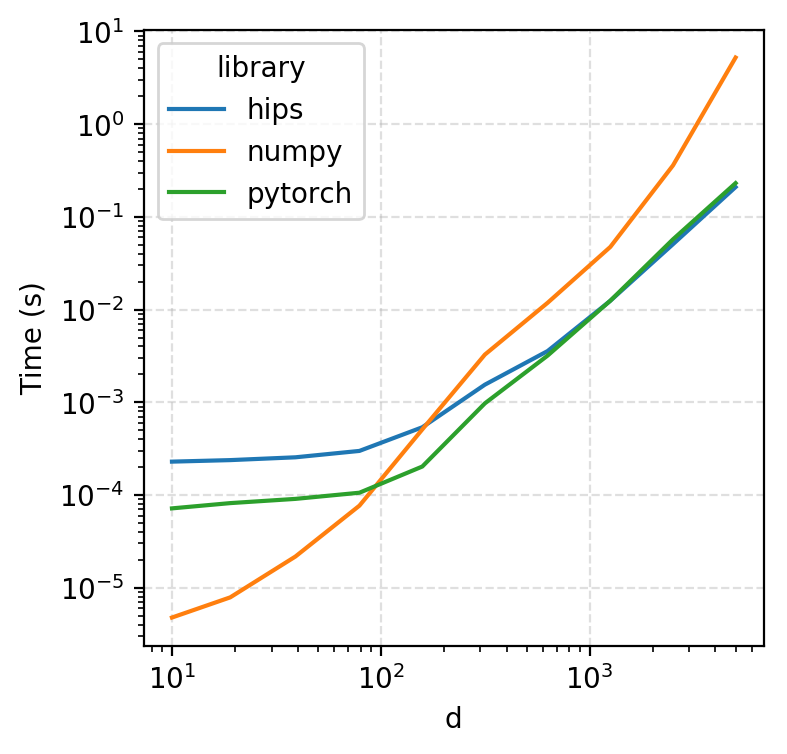

In [17]:
import matplotlib.pyplot as plt
# plt.style.use('presentation')
plt.style.use('default')
# plt.style.use('ggplot')
# plt.style.use('fivethirtyeight')
# plt.style.use('bmh')

fig, ax = plt.subplots(figsize=(4, ) * 2)
show.plot(logx=True, logy=True, ax=ax)
plt.ylabel('Time (s)')
# plt.grid(which='minor')
plt.grid(which='major', linestyle='--', alpha=0.4)
plt.savefig('grad-timings.png', dpi=300, bbox_inches='tight')

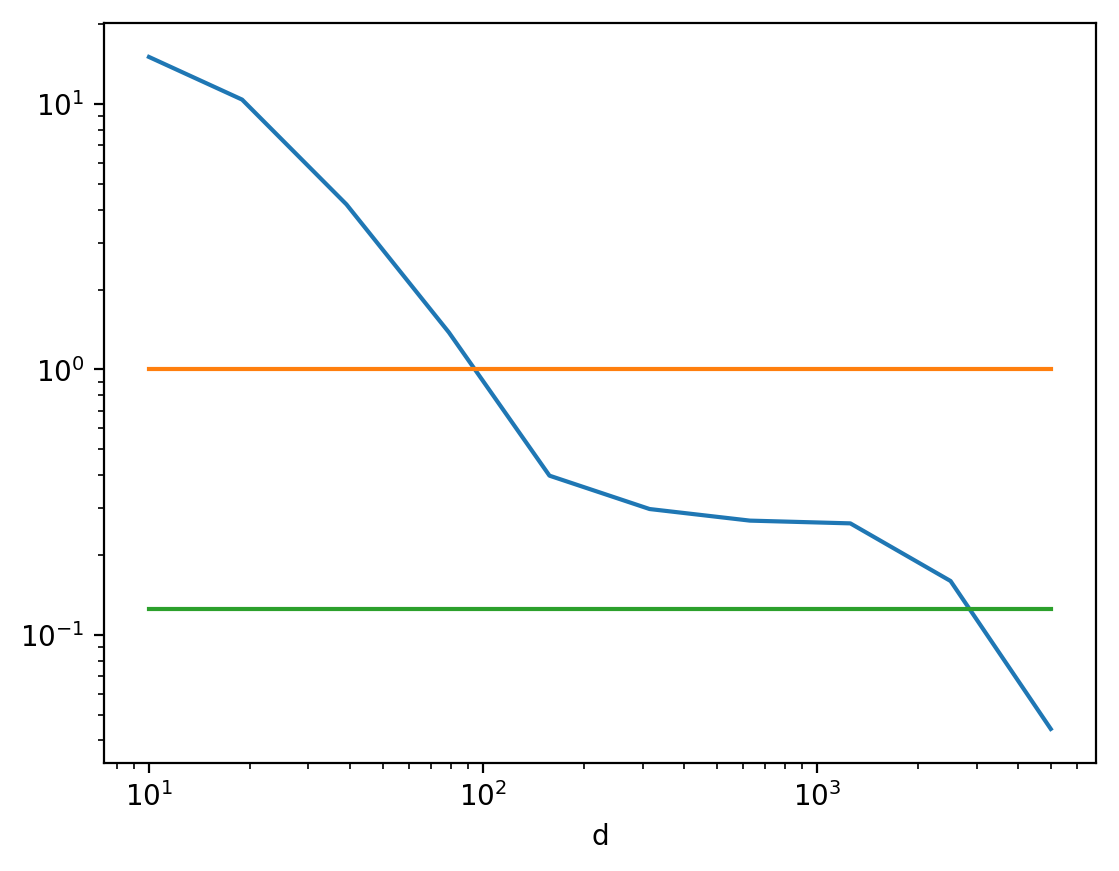

In [18]:
speedup = show['pytorch'] / show['numpy'] 
speedup.plot(logx=True, logy=True)
plt.plot([show.index.min(), show.index.max()], [1, 1])
# because I have 8 cores on this system
plt.plot([show.index.min(), show.index.max()], [1/8, 1/8])